## Explicabilidade

As decisões que são tomadas no mundo hoje estão cada vez mais ficando nas mãos dos sistemas de IA - desde definir quais pessoas terão direito a crédito até decidir quem será abordado pela polícia. Isso é motivado, claro, pela altíssima eficiência, assertividade, velocidade e escalabilidade dos modelos de IA. Porém, na grande maioria dos casos, os modelos empregados são _black boxes_: não nos preocupamos exatamente com o que está acontecendo dentro do modelo, e sim com o seu desempenho final. Por consequência, os códigos e scripts de machine learning raramente são escrutinizados e a interpretabilidade é sacrificada para favorecer a agilidade e o desempenho do modelo.

Na aula de hoje, falaremos um pouco sobre esse aspecto mais humano e social dos modelos de IA: a interpretabilidade (ou explicabilidade). A ideia aqui é, por exemplo, além de  prever uma classe, conseguir dizer _por quê_ a classe predita foi aquela. Também é importante estar atento aos impactos finais do uso do modelo, olhando para os desdobramentos sociais, econômicos e políticos envolvidos nessa utilização.

No contexto de empresas do ramo financeiro, por exemplo, um dos requisitos para os modelos de crédito é que eles sejam **explicáveis**: é necessário que um cliente possa questionar seu crédito, e o banco precisa conseguir responder adequadamente o que levou àquela decisão.

Também é importante notar que técnicas diferentes de ML possuem graus diferentes de explicabilidade e, de forma geral, quanto mais complexos os modelos, menor sua explicabilidade. No caso das técnicas de ensemble, por exemplo, uma random forest pode ser explicada e compreendida olhando o ganho médio de informação (no modelo) de cada variável. No caso dos modelos de boosting como o LightGBM, também podemos fazer essa análise mas o resultado não é interpretável como a random forest: não sabemos em quais árvores ela está sendo utilizada e consequentemente a distribuição do ganho de informação associado a ela. Redes neurais são notórias por serem praticamente impossíveis de interpretar, e são consideradas modelos _black box_. Contrário a isso, existem técnicas focadas na explicabilidade. Estas técnicas são chamadas de _glass box_ (sem consenso acadêmico quanto ao nome).

<br>

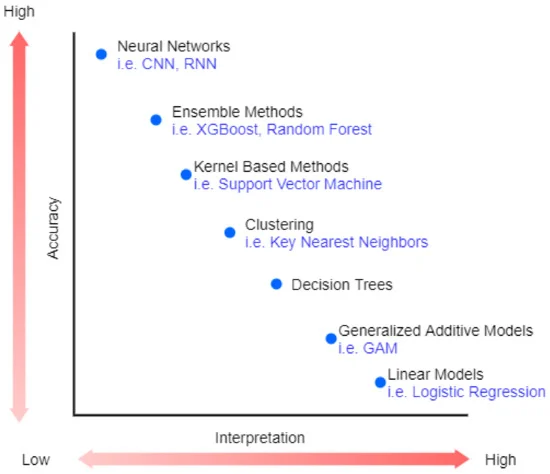

#### Feature importance

Um dos jeitos de explorarmos um pouco mais da heurística que o modelo aprendeu é exatamente verificar a importância de cada variável. No caso dos modelos de árvore, essa importância é normalmente definida como a média de ganho de informação (entropia ou gini) associada àquela variável nas árvores ajustadas. Já em modelos como a regressão linear, a importância de cada variável é definida como o coeficiente ajustado à cada variável.

Aqui existe uma sutileza: algumas _feature importances_ são **absolutas** - não representam uma "direção" pra qual a variável influencia, que é o caso dos modelos de árvore. Entretanto, no caso da regressão linear por exemplo, os coeficientes podem ser _negativos_, o que significa que influenciam negativamente na predição.

Vamos então ajustar alguns modelos e comparar as feature importances. Usaremos o dataset _Diabetes_ novamente, que já estamos familiarizados.

In [1]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np
import time
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)
df = pd.concat([cdc_diabetes_health_indicators.data.features, cdc_diabetes_health_indicators.data.targets], axis=1)

In [2]:
df.drop_duplicates(inplace=True)

In [3]:
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42)
model_cols = [c for c in df.columns if c!='Diabetes_binary']

##### Random Forest

In [4]:
from sklearn.ensemble import RandomForestClassifier
rfr = RandomForestClassifier(n_estimators=10,
                             max_depth=10,
                             class_weight='balanced',
                             min_samples_split=10,
                             n_jobs=-1)

rfr.fit(df_train[model_cols], df_train['Diabetes_binary'])

RandomForestClassifier(class_weight='balanced', max_depth=10,
                       min_samples_split=10, n_estimators=10, n_jobs=-1)

In [5]:
from sklearn.metrics import roc_auc_score
print('ROC-AUC treino:', roc_auc_score(df_train['Diabetes_binary'], rfr.predict_proba(df_train[model_cols])[:,1]))
print('ROC-AUC teste:', roc_auc_score(df_test['Diabetes_binary'], rfr.predict_proba(df_test[model_cols])[:,1]))

ROC-AUC treino: 0.8263982504157544
ROC-AUC teste: 0.8084246167908276


Temos uma random forest ajustada! Vamos calcular as _feature importances_:

In [6]:
# O atributo feature_importances_ do objeto do modelo carrega o que precisamos
rfr.feature_importances_

array([0.1700362 , 0.08025625, 0.01404056, 0.1306478 , 0.00355935,
       0.00367825, 0.02105524, 0.00930975, 0.0025996 , 0.00236617,
       0.00984388, 0.00287549, 0.00254117, 0.31591104, 0.01331209,
       0.02683551, 0.04258051, 0.00868894, 0.10669676, 0.00770933,
       0.02545613])

In [7]:
# Vamos juntar com o model_cols
dict(zip(model_cols, rfr.feature_importances_))

{'HighBP': 0.1700362027668412,
 'HighChol': 0.08025625285796076,
 'CholCheck': 0.014040557716600701,
 'BMI': 0.13064779665561593,
 'Smoker': 0.0035593475242070433,
 'Stroke': 0.003678249352257744,
 'HeartDiseaseorAttack': 0.021055235218691258,
 'PhysActivity': 0.009309748363127446,
 'Fruits': 0.00259960096655524,
 'Veggies': 0.0023661703092239996,
 'HvyAlcoholConsump': 0.009843880880716119,
 'AnyHealthcare': 0.0028754895556602172,
 'NoDocbcCost': 0.002541173017189019,
 'GenHlth': 0.3159110356515976,
 'MentHlth': 0.013312087232492002,
 'PhysHlth': 0.026835512829204135,
 'DiffWalk': 0.0425805062585756,
 'Sex': 0.00868894076937553,
 'Age': 0.10669675736358006,
 'Education': 0.007709328437296803,
 'Income': 0.025456126273231537}

In [8]:
# E tranformar em um dataframe
df_imports_rfr = pd.DataFrame(zip(model_cols, rfr.feature_importances_), columns=['feature', 'importance'])\
                   .sort_values(by='importance', ascending=False)
df_imports_rfr.head(5)

,feature,importance
13,GenHlth,0.315911
0,HighBP,0.170036
3,BMI,0.130648
18,Age,0.106697
1,HighChol,0.080256


Podemos observar que a variável "GenHlth", que mensura de forma macro a saúde geral do indivíduo, é a mais relevante para isolar os diabéticos. Em seguida, temos pressão alta, idade e IMC como variáveis mais importantes. Está fazendo sentido com o que conhecemos da doença! Mas... a variável de saúde geral e a variável de pressão alta influenciam da mesma forma? Faz sentido que quanto _maior_ a saúde geral, menor a chance de diabetes, e o contrário para a pressão alta. Porém, a importância absoluta das variáveis na random forest não nos dá essa noção.

Vamos então ajustar um modelo linear: a humilde regressão logística! Essa técnica aloca coeficientes para cada variável, e **estes coeficientes podem ser negativos**.

In [9]:
# Padronizando dados
# desnecessário na random forest, necessário pra logreg

from sklearn.preprocessing import StandardScaler
model_cols_norm = [s+'_norm' for s in model_cols]

scaler = StandardScaler()

df_train[model_cols_norm] = scaler.fit_transform(df_train[model_cols])
df_test[model_cols_norm] = scaler.transform(df_test[model_cols])

In [10]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(class_weight='balanced', max_iter=500)
logreg.fit(df_train[model_cols_norm], df_train['Diabetes_binary'])

LogisticRegression(class_weight='balanced', max_iter=500)

In [11]:
from sklearn.metrics import roc_auc_score
print('ROC-AUC treino:', roc_auc_score(df_train['Diabetes_binary'], logreg.predict_proba(df_train[model_cols_norm])[:,1]))
print('ROC-AUC teste:', roc_auc_score(df_test['Diabetes_binary'], logreg.predict_proba(df_test[model_cols_norm])[:,1]))

# Note que agora pegaremos o atributo coef_ da regressão logística,
# que representa os coeficientes da função aprendida
df_imports_logreg = pd.DataFrame(zip(model_cols, logreg.coef_[0]), columns=['feature', 'importance'])\
                   .sort_values(by='importance', ascending=False)
df_imports_logreg.head(5)

ROC-AUC treino: 0.8068083826826067
ROC-AUC teste: 0.8093726863922203


,feature,importance
13,GenHlth,0.572609
3,BMI,0.468872
18,Age,0.443989
0,HighBP,0.355845
1,HighChol,0.275745


Note que os coeficientes têm soma $>1$. Vamos normalizá-los:

In [12]:
df_imports_logreg['importance_rel'] = df_imports_logreg['importance'] / df_imports_logreg['importance'].sum()

E criar uma coluna absoluta para ordenar o dataset:

In [13]:
df_imports_logreg['importance_abs'] = df_imports_logreg['importance'].apply(abs)

In [14]:
df_imports_logreg.sort_values(by='importance_abs', ascending=False)

,feature,importance,importance_rel,importance_abs
13,GenHlth,0.572609,0.252368,0.572609
3,BMI,0.468872,0.206648,0.468872
18,Age,0.443989,0.195681,0.443989
0,HighBP,0.355845,0.156833,0.355845
1,HighChol,0.275745,0.121530,0.275745
2,CholCheck,0.264055,0.116378,0.264055
10,HvyAlcoholConsump,-0.181881,-0.080161,0.181881
17,Sex,0.144539,0.063703,0.144539
20,Income,-0.102660,-0.045246,0.102660
6,HeartDiseaseorAttack,0.067858,0.029907,0.067858


Surpreendentemente, o consumo pesado de álcool contribui negativamente pra predição - isto é, a relação é mais forte entre quem consome álcool e quem **não tem diabetes** do que quem consome álcool e tem! Também podemos observar que, ao contrário do que esperávamos, a variável "GenHlth" contribui _positivamente_ para a presença da doença. Isso se dá ao fato de que essa variável possui escala invertida:

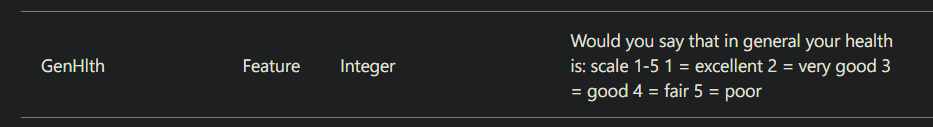

Além disso, observamos que "Income" (renda) também contribui negativamente - muito provavelmente porque as pessoas com melhores condições financeiras têm mais acesso à saúde, à informação e consequentemente à prevenção da doença.

##### Outras técnicas

Existem algumas técnicas diferentes para explicar modelos de machine learning. Enquanto observar a importância das variáveis e fazer análises estratificadas são duas abordagens básicas e simples de implementar, elas não nos dão informações sobre amostras individuais, e não fazem muito sentido em modelos _black box_. Nesse quesito, técnicas como o SHAP (https://github.com/shap/shap) podem nos dizer mais sobre a relação das variáveis de uma forma interpretável. Há também uma implementação recente de um algoritmo de _boosting_ chamado _Explainable Boosting Machine_ (https://interpret.ml/docs/ebm.html), que nos permite investigar a importância de variáveis (e combinações delas) a níveis individuais, por amostra. Também é possível explorar técnicas da estatística clássica como inferência causal com algoritmos específicos de ML, como as _Causal Forests_ (https://lost-stats.github.io/Machine_Learning/causal_forest.html).

É necessário implementar técnicas deste tipo para problemas onde é necessário modelos explicáveis e transparentes, ou em problemas onde há um viés muito nítido que deve ser mitigado.

## Viés algorítmico

Mesmo utilizando técnicas para interpretabilidade dos modelos, ainda há um grande problema ético: o viés presente nos dados. Um exemplo muito evidente disto é em recentes modelos de texto, como o ChatGPT e Google Bard, que reproduzem de forma quase inconspícua discursos sexistas. Estes modelos são treinados inicialmente para prever a próxima palavra de uma sentença, e devido à presença desse viés em uma parcela significativa dos dados de treino, farão previsões como:

<br>
<center><bold>FulanA é uma <u>enfermeira</u>.</bold></center>
<center><bold>FulanA é uma <u>doméstica</u>.</bold></center>
<br>
<center><bold>FulanO é um <u>médico</u>.</bold></center>
<center><bold>FulanO é um <u>engenheiro</u>.</bold></center>
<br>

Este é um tipo de comportamento perigoso, pois é sutil e difícil de notar, e está perpetuando e fortalecendo um discurso antiquado, de épocas passadas e incompatível com o mundo contemporâneo - e por consequência _errôneo_.

Este mesmo comportamento existe em outras esferas sensíveis, como discussões e recortes de raça e cor, sexualidade, nacionalidade e condições físicas. Também não é limitado somente a modelos de texto - recentemente, um modelo generativo de imagens respondeu à um prompt do tipo "desenhe um homem branco assaltando uma loja" com uma imagem gerada de um homem **negro**, vestido e coberto por roupas completamente brancas, assaltando uma loja. Embora a confusão de uma IA seja engraçado ou inofensivo na visão de algumas pessoas, é necessário pensar na enorme escala que as IAs atingiram globalmente e no dano que este tipo de comportamento pode causar, reforçando padrões sociais negativos e fortalecendo de forma geral os discursos de ódio.

Ainda não há um consenso geral na academia de como abordar e mitigar esse problema, mas é possível adicionar instruções (_guardrails_) aos modelos que aceitam prompts que explicitamente bloqueiam estes comportamentos. Entretanto, é impossível determinar se um conjunto de instruções em texto é o suficiente para limitar o comportamento de um modelo com mais de 7 bilhões de parâmetros (GPT-3).

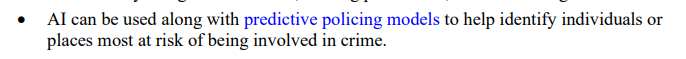

A polícia de forma geral também tem utilizado vários sistemas de inteligência artificial (https://crsreports.congress.gov/product/pdf/IN/IN12289) para diversas tarefas nobres, como perícia de feridas, reconhecimento facial, reconhecimento de voz e leitura automática de placas de veículos. Porém, há um risco enorme dos modelos serem **racistas**, simplesmente devido ao viés presente nos dados. Em particular, o uso de modelos de ML preditivos para mensurar _risco_, ou _probabilidade de crime_, serão fortemente influenciados pela condição econômica (e consequente cor da pele em alguns lugares) do indíviduo ou local analisado. Outro exemplo de um modelo que propaga um viés racista é um app (que rapidamente foi tirado do ar) que gera pinturas renascentistas a partir de uma selfie. Porém, pessoas negras viravam pinturas de pessoas brancas! Isso, obviamente, não significa que quem construiu o modelo seja racista, e sim que permitiu (provavelmente por inatenção) a propagação de um viés presente nos dados.

### Ética em modelagem

Há uma forma ainda mais sutil em que os vieses se manifestam: distribuição de poder preditivo diferente quando analisado estratificado por uma variável sensível. Ou seja, nosso modelo pode funcionar muito bem pra um grupo de pessoas, e não funcionar para outro grupo! Um exemplo são modelos de logística de pessoas para projetar um "escoamento" adequado e controle de multidão: nesse caso, assumimos que todas as pessoas presentes estão em condições físicas similares e conseguem caminhar normalmente, o que não é o caso de muitas pessoas.

É extremamente importante estarmos atentos ao público final dos nossos modelos, e compreender quais vieses podem estar presentes nos dados e as técnicas disponíveis para mitigá-los (que por enquanto ainda não são muitas). Em todas as corporações e iniciativas sérias, a responsabilidade pelo modelo **é de quem o construiu**, então por mais que a intenção seja nobre, o impacto causado pode ser extremamente danoso e prejudicial para quem treinou o modelo.

Como portadores de conhecimento que pode contribuir **muito significativamente** para o desenvolvimento da humanidade, precisamos garantir que este conhecimento seja usado **para o bem** - com grandes poderes, vêm grandes responsabilidades, afinal. Carregamos conosco e nossos modelos a responsabilidade pelo bem estar e até pela vida de múltiplas pessoas, e estaremos convictos de que, apesar de muitas vezes relativizado, queremos sempre o bem da maior parte possível de pessoas de forma justa, honesta e transparente.

Um exemplo de uso desonesto muito pertinente é a cisão política atual do Brasil, que foi em grande parte engrandecida pelas mídias sociais e os algoritmos de recomendação patrocinados, o que acabou criando "bolhas" e "câmaras de eco" onde o diálogo só existe com pessoas que pensam similarmente de forma política. Vivemos em um contexto onde o diálogo político, a compreensão e a busca pelo bem-estar coletivo foram deixados de lado pelo conforto de ter suas ideias reafirmadas por outros indivíduos de pensamento semelhante - tudo isso com a ajuda de modelos de inteligência artificial.

### Exercícios

- Escolha uma técnica e um dataset de aulas passadas, analise as respectivas _feature importances_ e possíveis quebras por variáveis sensíveis. O modelo acerta mais um grupo do que outro? Existe alguma variável muito relevante para a predição, porém polêmica quanto ao uso?
- Implemente um _Explainable Boosting Machine_ em um dataset de sua escolha. Escolha 3 amostras do dataset e explique individualmente as predições de cada uma, observando a influência de cada variável por amostra.